In [1]:
# using PCA as a way of reducing dimension 
# use adaboost to train the learning model.

In [2]:
import pandas as pd
import numpy as np
import os

from time import time
from sklearn.datasets import make_hastie_10_2
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, auc
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from skimage.feature import hog

In [3]:
# define the path here
NAMES_PATH = "./archive/lfw_allnames.csv"
IMAGES_PATH = "./archive/lfw-deepfunneled/lfw-deepfunneled"


In [4]:
df_names = pd.read_csv(NAMES_PATH)
# To get a better performance, here we set a lower bound for the size of the dataset
min_faces_per_person = 80 
df_names = df_names.loc[df_names["images"] >= min_faces_per_person, :]
names = list(df_names["name"])
K = len(names)
names

['Colin_Powell',
 'Donald_Rumsfeld',
 'George_W_Bush',
 'Gerhard_Schroeder',
 'Tony_Blair']

In [5]:
# data preprocessing procedure
X = []
Y = []
for name in names:
    dir_path = os.path.join(IMAGES_PATH, name)
    list_images_name = os.listdir(dir_path)
    for image_name in list_images_name:
        image_path = os.path.join(dir_path, image_name)
        img_rgb = plt.imread(image_path)
        X.append(img_rgb)
        Y.append(name)
    print(f"Class: {name}, number of samples: {len(list_images_name)}.")

X = np.asarray(X)
Y = np.asarray(Y)

print(X.shape, Y.shape)

Class: Colin_Powell, number of samples: 236.
Class: Donald_Rumsfeld, number of samples: 121.
Class: George_W_Bush, number of samples: 530.
Class: Gerhard_Schroeder, number of samples: 109.
Class: Tony_Blair, number of samples: 144.
(1140, 250, 250, 3) (1140,)


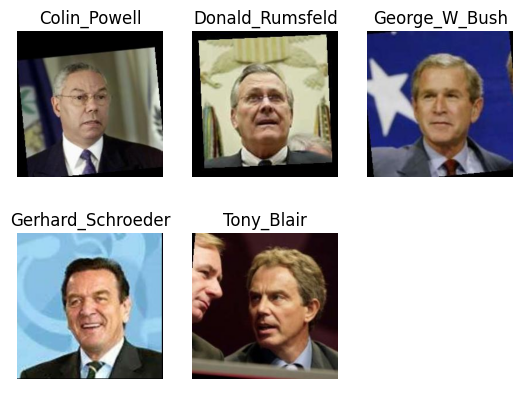

In [6]:
# an overview of the pictures
_, indices = np.unique(Y, return_index=True)
columns = 3
rows = (len(indices) // columns) + 1
fig, axs = plt.subplots(frameon=False)
axs.axis('off')

for itr, idx in enumerate(indices):
    # Adds a subplot at the 2nd position 
    fig.add_subplot(rows, columns, itr+1) 
    plt.axis('off')
    plt.title(Y[idx]) 
    plt.imshow(X[idx])
    
plt.show()

In [7]:
# Extract Features: Colors and HOG(Histogram of Gradient)
def create_features(img, show_hog=False):
    # flatten image
    color_features = img.flatten()
    # convert image to greyscale
    grey_image = np.array(0.299 * img[:, :, 0] + 0.587 * img[:, :, 1] + 0.114 * img[:, :, 2])
    # get HOG features from greyscale image
    hog_features, hog_image = hog(grey_image, visualize=True, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    if show_hog:
        plt.imshow(hog_image, cmap="gray")
    # combine color and hog features into a single array -- our final feature result
    flat_features = np.hstack((color_features, hog_features))
    return flat_features

In [8]:
feature_matrix = []
for x in X:
    feature_matrix.append(create_features(x))

In [9]:
# get shape of feature matrix
feature_matrix = np.asarray(feature_matrix)
print('Feature matrix shape is: ', feature_matrix.shape)

# define standard scaler and apply this on the dataset.
ss = StandardScaler()
# run this on our feature matrix
face_stand = ss.fit_transform(feature_matrix)

# use fewer dimensions to represent the information of data.
pca = PCA(n_components=500)
# use fit_transform to run PCA on our standardized matrix
pca.fit(face_stand)
# when the model is well-trained, if we feed data into the model
# we can get the output of data which is after the reduction of dimension.
X_pca = pca.transform(face_stand)

# face_pca is the standardized 
face_pca = ss.fit_transform(X_pca)
print("PCA matrix shape is: ", face_pca.shape)

Feature matrix shape is:  (1140, 201189)
PCA matrix shape is:  (1140, 500)


In [10]:
# label_encoder object knows  
# how to understand word labels. 
label_encoder = LabelEncoder() 
  
# Encode labels in column 'species'. 
Y = label_encoder.fit_transform(Y) 

In [11]:
# "face_pca" is the matrix of input data.
X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y, random_state=42)

In [12]:
def get_error_rate(predict, real):
    assert len(predict) == len(real), "Wrong size of Y(predictY_size != RealY_size)"
    return sum(predict!=real)/float(len(real))

In [13]:
def generic_clf(Y_train, X_train, Y_test, X_test, clf):
    clf.fit(X_train,Y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    return get_error_rate(pred_train, Y_train), \
           get_error_rate(pred_test, Y_test)

In [14]:
# START: OWN CODE
# implementation of SAMMA
def adaboost_clf(Y_train, X_train, Y_test, X_test, M, clf):
    lr = 1
    # clf is a weak learner.
    n_train, n_test = len(X_train), len(X_test)
    # Initialize weights
    w = np.ones(n_train) / n_train
    
    # For k class, we have k kinds of probability -- good classification result.
    class_k_train = [np.zeros(n_train) for _ in range(K)]
    class_k_test = [np.zeros(n_test) for _ in range(K)]
    
    # Here the M means we have M different weak classifiers to make decisions.
    for i in range(M):
        # Fit a classifier with the specific weights
        clf.fit(X_train, Y_train, sample_weight = w)
        pred_train_i = clf.predict(X_train)
        pred_test_i = clf.predict(X_test)
        
        # Indicator function
        miss = [int(x) for x in (pred_train_i != Y_train)]
        # Error
        err_m = np.dot(w,miss) / sum(w)
        # Alpha 为什么是个标量？？？？？？？难道不是针对序列的一个向量么？
        alpha_m = lr * np.log( (1 - err_m) / float(err_m)) + np.log(K-1)
        # New weights
        w = np.multiply(w, np.exp([float(x) * alpha_m for x in miss]))

        # renormalize wi
        w_sum = np.sum(w, axis=0)
        w = w/w_sum
        
        # prediction of class C(x)
        for i in range(K):
            Ii = (np.array(pred_train_i) == i).astype(float)
            class_k_train[i] += Ii*alpha_m

            Ii_test = (np.array(pred_test_i) == i).astype(float)
            class_k_test[i] += Ii_test*alpha_m

    # pred_train, pred_test = np.sign(pred_train), np.sign(pred_test)
    # Return error rate in train and test set
    # output the index of the chosen class.
    pred_train = np.argmax(class_k_train,axis=0)

    pred_test = np.argmax(class_k_test, axis=0)
    return get_error_rate(pred_train, Y_train), \
           get_error_rate(pred_test, Y_test)
# END: OWN CODE

In [15]:
def plot_error_rate(er_train, er_test):
    df_error = pd.DataFrame([er_train, er_test]).T
    df_error.columns = ['Training', 'Test']
    plot1 = df_error.plot(linewidth = 3, figsize = (8,6),
            color = ['lightblue', 'darkblue'], grid = True)
    plot1.set_xlabel('Number of iterations', fontsize = 12)
    # plot1.set_xticklabels(range(0,450,10))
    plot1.set_ylabel('Error rate', fontsize = 12)
    plot1.set_title('Error rate vs number of iterations', fontsize = 16)
    
    plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40], [0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.axhline(y=er_test[0], linewidth=1, color = 'red', ls = 'dashed')

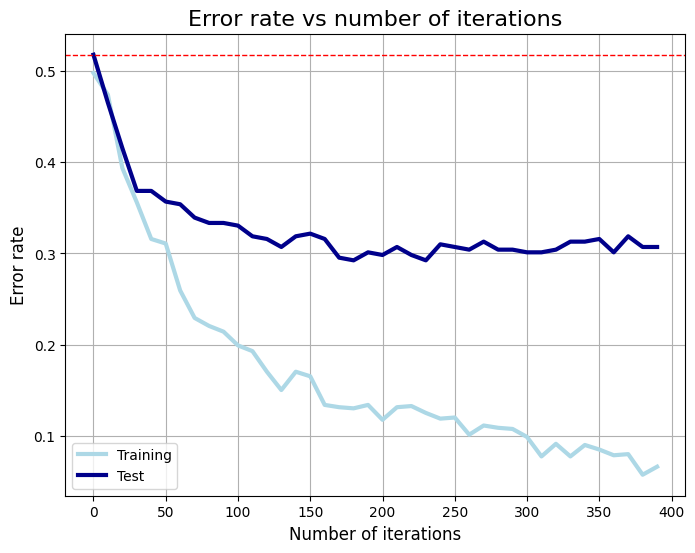

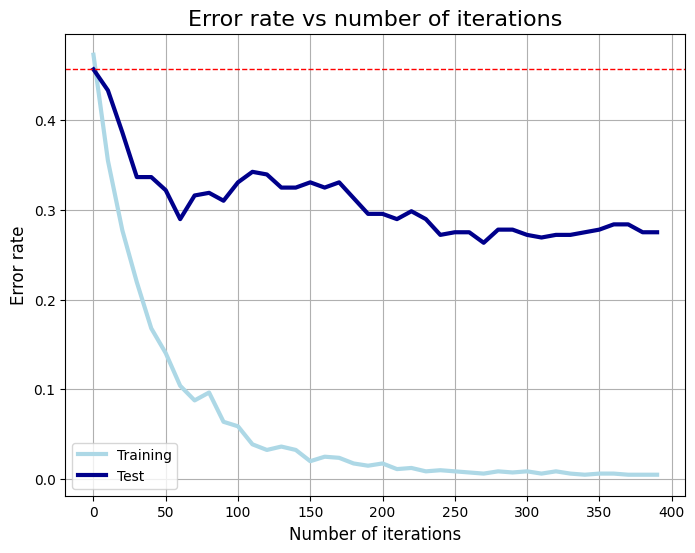

In [16]:
# START: OWN CODE
if __name__ == '__main__':
    X_train, X_test, Y_train, Y_test = train_test_split(face_pca, Y, random_state=42,test_size=0.3)
    # Fit a weak learner -- Decision Tree
    clf_tree1 = DecisionTreeClassifier(max_depth=1, random_state=30)
    clf_tree2 = DecisionTreeClassifier(max_depth=2, random_state=30)
    
    error_tree1 = generic_clf(Y_train,X_train,Y_test,X_test,clf_tree1)
    error_tree2 = generic_clf(Y_train,X_train,Y_test,X_test,clf_tree2)

    error_train1, error_test1 = [error_tree1[0]] ,[error_tree1[1]]
    error_train2, error_test2 = [error_tree2[0]] ,[error_tree2[1]]

    x_range = range(10, 400, 10) # 10, 410.
    for i in x_range:
        error_i1 = adaboost_clf(Y_train,X_train,Y_test,X_test, i, clf_tree1)
        error_train1.append(error_i1[0])
        error_test1.append(error_i1[1])
        
        error_i2 = adaboost_clf(Y_train,X_train,Y_test,X_test, i, clf_tree2)
        error_train2.append(error_i2[0])
        error_test2.append(error_i2[1])
    plot_error_rate(error_train1,error_test1)
    plot_error_rate(error_train2,error_test2)
    
# END: OWN CODE

In [17]:
error = np.min(error_test2)
print("My_adaboost_detector accuracy: {:.2%}".format(1- error))

My_adaboost_detector accuracy: 73.68%


In [25]:
# Below is the implementation of adaboost in sklearn
from sklearn.ensemble import AdaBoostClassifier

error_test = []
error_train = []

for i in x_range:
    skit_clf = AdaBoostClassifier(n_estimators = i, random_state=0)
    skit_clf.fit(X_train,Y_train)
    error_train.append(1- skit_clf.score(X_train,Y_train))
    error_test.append(1- skit_clf.score(X_test,Y_test))

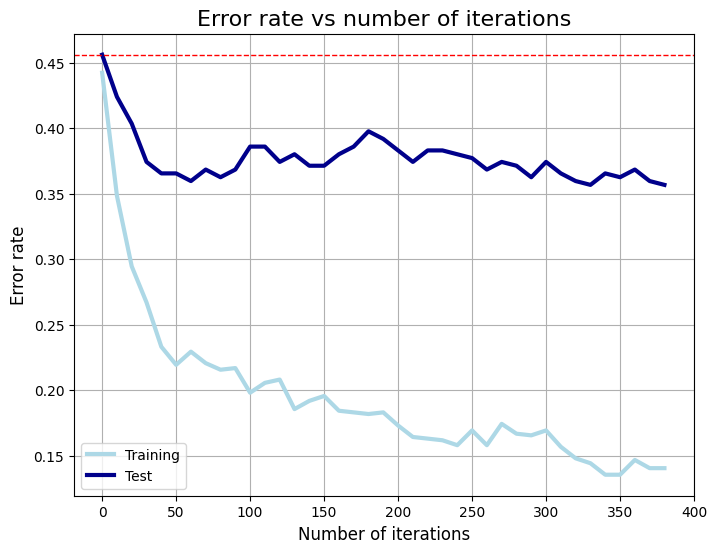

In [26]:
plot_error_rate(error_train, error_test)